# Initialization

In [4]:
# DATA ACQUISITION
import urllib.request, urllib.parse, urllib.error
from urllib.request import Request, urlopen
import ssl
import re
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# DATA STORAGE AND PROCESSING
import numpy as np
import pandas as pd
import datetime

# VISUALIZATION
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython

# MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# NEURAL NETWORKS
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh, mean_squared_error

# Data Acquisition

The insight archive contains links to all blog posts published in different years. For each year, there is a subpage with the links to the posts.

Each blog post contains a header with the title, author, publication date, etc., followed by the main text with a number of graphics and hyperlinks. Also, there is a pop-up for each post that indicates the number of "claps" given by the reader.

<img src="img/blog.png" alt="drawing" width="1200"/>

### Crawl INSIGHT archive for blog posts

In [5]:
# Define criteria for relevant links
exclude = ("/archive", "@", "responses", "tagged")

# Create empty list of blog posts
posts = []

# Crawling the archive
for year in range(2013, 2020):
    url = "https://blog.insightdatascience.com/archive/%d" % (year)
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(req).read()
    
# Parsing the archive to find all outgoing links
    links = re.findall(b'href="(https://blog.insightdatascience.com/.*?)"', html)
    
# Find links to blog posts
    for link in links:
        if any(s in link.decode() for s in exclude):
            continue
        posts.append(link.decode())

# Delete dublicate links
posts = list(set(posts))

# Challenges:
# - In regular expressions not r (raw), but b (byte)
# - web access with urllib.request.urlopen(url, context=ctx).read() blocked
# - HTML parser does not work on website (beautifulsoup4). Had to do it manually.
# - Archive contains several not used links

### Parse and Store Data

In [6]:
# Create dataframe for information from blog posts
columnnames = ["claps", "title", "author", "publication date", "number of graphics", "text length"\
               , "number of hyperlinks", "title length"]
characteristics = pd.DataFrame(columns = columnnames)

# Parse blog posts
for url in posts:
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(req).read()

# Regex-parse posts to find characteristics
    claps = re.search(r"([0-9]|\.|K)+(?= claps<\/button>)", html.decode()) # positive lookahead
    if claps:
        claps = claps.group(0)
    title = re.search(r"(?<=<title>).*(?=</title>)", html.decode())
    if title:
        title = title.group(0)
    author = re.search(r"(?<={\"@type\":\"Person\",\"name\":\").*?(?=\",\"url\":)", html.decode())
    if author:
        author = author.group(0)
    date = re.search(r"(?<=article:published_time\" content=\").*?(?=T)", html.decode())
    if date:
        date = date.group(0)
    num_graphics = len(re.findall(b'<img class=', html))
    len_html = len(html)
    len_title = len(title)
    num_links = len(re.findall(b'href=', html))
    
# Add identified properties to dataframe
    post_char = pd.DataFrame([[claps, title, author, date, num_graphics, len_html, num_links, len_title]]\
                             , columns = columnnames)
    characteristics = characteristics.append(post_char, ignore_index=True)
    
# Initialize for next iteration
    claps = title = author = date = num_graphics = len_html = num_links = len_title = None
    
print(characteristics.head(10))

   claps                                              title            author  \
0    121  MapMyCab: How I Chose a Data Engineering Proje...      Insight Data   
1      8  Named Entity Recognition: Examining the Stanfo...      Insight Data   
2  16.3K  How to solve 90% of NLP problems: a step-by-st...  Emmanuel Ameisen   
3   2.4K  Always start with a stupid model, no exception...  Emmanuel Ameisen   
4      3  Find and Watch TV Shows on YouTube with CouchT...      Insight Data   
5      7  Inspector Git: Discover Awesome New Repositori...      Insight Data   
6    406  Data Visualization in Python: Advanced Functio...      Insight Data   
7    104  Graph-based machine learning: Part I – Insight...    Sebastien Dery   
8    878  Airflow 101: Start automating your batch workf...   Sriram Baskaran   
9   2.5K  Heart Disease Diagnosis with Deep Learning – I...     Chuck-Hou Yee   

  publication date number of graphics text length number of hyperlinks  \
0       2015-06-09                

# Data Cleaning

In [7]:
# Delete entries with no publication date
characteristics.drop(characteristics[characteristics["publication date"].isnull()].index, inplace=True)

# Adjust data types
characteristics[["claps", "title", "author", "publication date"]] = \
    characteristics[["claps", "title", "author", "publication date"]].astype(str)

# Claps: Replace None with 0
characteristics.replace("None", 0, inplace=True)

# Claps: Replace K with 1000s
def thousands(x):
    if "K" in str(x):
        return 1000*float(str(x[:-1]))
    else:
        return x
characteristics["claps"] = characteristics["claps"].apply(thousands)
characteristics["claps"] = characteristics["claps"].astype(float).astype(int)

# Create column for time (in days) since first blog post
characteristics["publication date"] = characteristics["publication date"]\
    .apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
characteristics["datedelta"] = characteristics["publication date"]\
    .apply(lambda x: (x-min(characteristics["publication date"])).days)

# Create column for publication year
characteristics["year"] = characteristics["publication date"].astype(str).apply(lambda x: x[:4])

# Sort Dataframe by Claps
characteristics = characteristics.sort_values(by=['claps'])

print(characteristics)

    claps                                              title  \
0     121  MapMyCab: How I Chose a Data Engineering Proje...   
1       8  Named Entity Recognition: Examining the Stanfo...   
2   16300  How to solve 90% of NLP problems: a step-by-st...   
3    2400  Always start with a stupid model, no exception...   
4       3  Find and Watch TV Shows on YouTube with CouchT...   
5       7  Inspector Git: Discover Awesome New Repositori...   
6     406  Data Visualization in Python: Advanced Functio...   
7     104  Graph-based machine learning: Part I – Insight...   
8     878  Airflow 101: Start automating your batch workf...   
9    2500  Heart Disease Diagnosis with Deep Learning – I...   
10     18               Preparing for Insight – Insight Data   
11    846  Crash Catcher: Detecting Car Crashes in Video ...   
12      0  Insight Data Science Fellows Program launches ...   
13    303  Preparing for the Transition to Data Science –...   
14    217  Scheduling Spark jobs with Ai

### Detection of Outliers

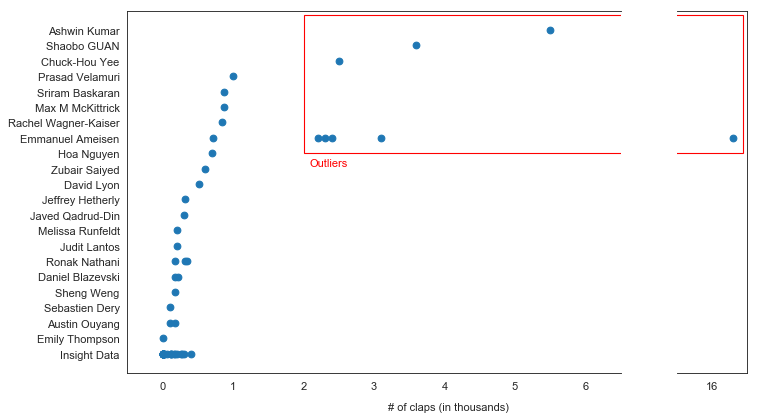

In [8]:
# Create Figure
f,(ax,ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 6), dpi= 80\
                          , facecolor='w', edgecolor='k', gridspec_kw = {'width_ratios':[7, 1]})

# Plot data
ax.scatter(characteristics['claps'], characteristics['author'])
ax2.scatter(characteristics['claps'], characteristics['author'])

# Adjust axes
ax.set_xlim(-500,6500)
ax2.set_xlim(15500,16500)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

ax.set(xlabel='# of claps (in thousands)')
ax.xaxis.set_label_coords(0.65, -0.08) 

ax.set_xticks(np.linspace(0,6000,7).astype(int))
ax.set_xticklabels(np.linspace(0,6,7).astype(int), fontdict=None, minor=False)

ax2.set_xticks([16000])
ax2.set_xticklabels([16], fontdict=None, minor=False)

# Create rectangle to mark outliers
rect = mpl.patches.Rectangle((2000,13),7000,9,linewidth=1,edgecolor='r',facecolor='none')
rect2 = mpl.patches.Rectangle((15000,13),1440,9,linewidth=1,edgecolor='r',facecolor='none')

ax.add_patch(rect)
ax2.add_patch(rect2)

ax.text(2080,12.2, 'Outliers', fontsize=10, color='red')

plt.show()

# Drop Outliers (since they tend to throw off the machine learning)
# Only consider posts with less than or equal 1000 claps and less than or equal 190000 words
characteristics_reduced = characteristics.drop(characteristics[characteristics["claps"] > 1000].index).copy()
characteristics_reduced = characteristics_reduced\
    .drop(characteristics_reduced[characteristics_reduced["text length"] > 190000].index).copy()

Number of claps for posts sorted by author. In order to fit trends with ML model, outliers are droped from database.

# Interpretation

### Investigation of correlations

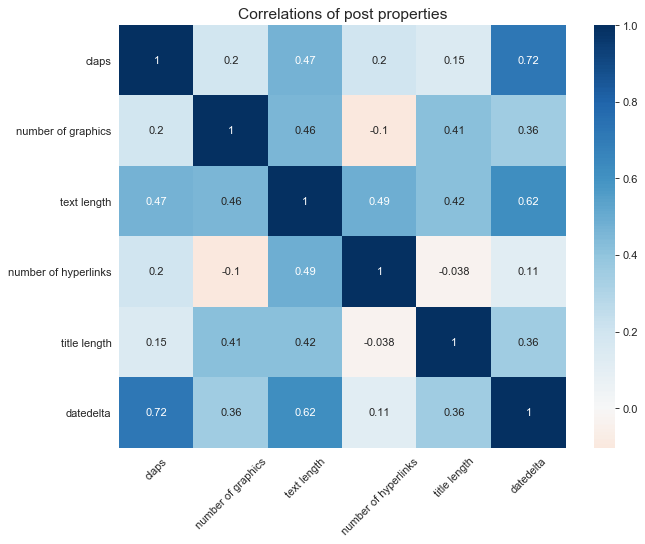

In [9]:
# Create heatmap to visualize correlations
plt.figure(figsize=(9,7), dpi= 80)
h = sns.heatmap(characteristics_reduced.corr(), xticklabels=characteristics_reduced.corr().columns\
            , yticklabels=characteristics_reduced.corr().columns, cmap='RdBu', center=0, annot=True)

# Set decorations
plt.title('Correlations of post properties', fontsize=14)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()

Database is very small. In order to reduce risk of overfitting we want to use a small number of features (less synapses in the network to fit). The correlogram reveals which properties are most useful.

High correlation between text length and claps. Viewers seems to like longer texts. But need to have a closer look: Correlation between text length and datedelta reveals that more recently published posts tend to be longer. Furthermore, the correlation between the date and the claps is very high, indicating that the number of viewers increased and thus the number of claps per post.

### Distribution and Linear Regression of Data

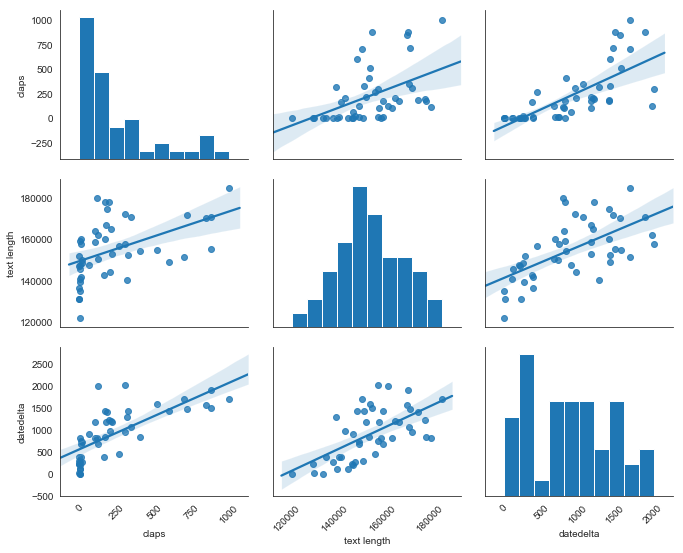

In [13]:
# Create regression plot
sns.set_style("white")
p = sns.pairplot(characteristics_reduced[(['claps', 'text length', 'datedelta'])]\
                 , height=2.5, aspect=1.25, kind='reg')

# Adjust x-axis
for ax in p.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)


Most articles have few claps and an intermediate length. Number of articles per time more or less constant.

Claps seem to increase with text length (21). But both, text length and claps increase with publishing time(32, 31)!

The same reasoning does, however, not apply for the number of hyperlinks (very low correlation with publishing time)!

# Machine Learning

### Prepare Data

In [20]:
# Select data
dataset = characteristics_reduced[["claps", "datedelta", "number of hyperlinks", "text length"]].values

# Split data into input (X) and output (Y) variables
X = dataset[:,1:3].astype(float)
Y = dataset[:,0].astype(float)

# Scale data
scalerY = MinMaxScaler()
scalerY.fit(Y.reshape(len(Y),1))
Y = scalerY.transform(Y.reshape(len(Y),1))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

### Define and Train Neural Network

In [21]:
# Define model (Multilayer Perceptron)
model = Sequential()
model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
# model.add(Dense(2, input_dim=2, kernel_regularizer=regularizers.l2(0.1), kernel_initializer='normal', activation='relu'))
# model.add(Dense(1, kernel_initializer='normal', activation='linear'))
# model.compile(loss='mse', optimizer='adam')

# Compile model
model.compile(loss='logcosh', optimizer='adam')

# Train Neural Net
model.fit(X_train, y_train, batch_size=1, epochs=150, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Make Predictions

In [28]:
# Predict claps for test set
y_pred = model.predict(X_test)

# Invers-scale data
y_pred_inv = scalerY.inverse_transform(y_pred)
y_test_inv = scalerY.inverse_transform(y_test)

# Compare actual and predicted claps
for i in range(len(X_test)):
    print("Actual=%s,\tPredicted=%s,\tDifference=%s" % (y_test_inv[i], y_pred_inv[i], abs(y_pred_inv[i]-y_test_inv[i])))

Actual=[173.],	Predicted=[250.65384],	Difference=[77.65383911]
Actual=[121.],	Predicted=[378.71686],	Difference=[257.71685791]
Actual=[515.],	Predicted=[378.71686],	Difference=[136.28314209]
Actual=[317.],	Predicted=[378.71686],	Difference=[61.71685791]
Actual=[0.],	Predicted=[104.142395],	Difference=[104.14239502]
Actual=[0.],	Predicted=[22.289932],	Difference=[22.28993225]
Actual=[207.],	Predicted=[378.71686],	Difference=[171.71685791]
Actual=[263.],	Predicted=[4.4234095],	Difference=[258.57659054]
Actual=[878.],	Predicted=[378.71686],	Difference=[499.28314209]
Actual=[178.],	Predicted=[378.71686],	Difference=[200.71685791]
Actual=[104.],	Predicted=[345.96893],	Difference=[241.96893311]
Actual=[324.],	Predicted=[378.71686],	Difference=[54.71685791]


### Visualize Predictions

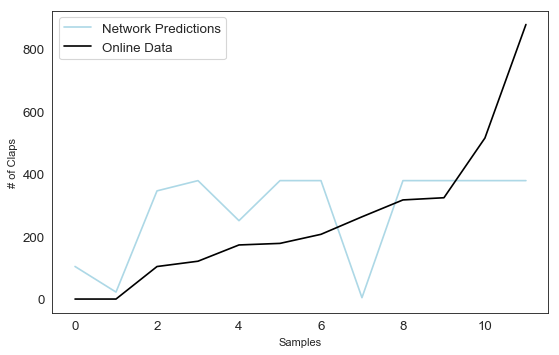

In [29]:
# Sort Data
pred_data = pd.DataFrame({'y_test':np.squeeze(y_test_inv), 'y_pred':np.squeeze(y_pred_inv)})
pred_ordered = pred_data.sort_values('y_test')

# Create Figure
plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')

# Plot Predictions
plt.plot(pred_ordered.y_pred.values, color='lightblue', label='Network Predictions')
plt.plot(pred_ordered.y_test.values, color='black', label='Online Data')

# Decorations
plt.gca().set(xlabel='Samples', ylabel='# of Claps')
plt.legend(fontsize=12)
plt.xticks(fontsize=12); plt.yticks(fontsize=12)

plt.show() 